In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

In [2]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation']

In [3]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...


## Tokenize translated text

In [99]:
#tokenize single columns
#from nltk.tokenize import word_tokenize
#colname = 'designation_translated' #'designation'
#data['tokens'] = data[colname].str.lower().apply(lambda x: word_tokenize(x, language='french'))

In [4]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Load stopwords from NLTK

In [5]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('french'))
new_stop_words = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
stop_words.update(new_stop_words)

## Remove stopwords from tokens

In [6]:
def remove_stopwords(words, stopwords):
    #remove words in stopwords
    words_filtered = [word for word in words if word not in stopwords]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [8]:
#Removing stop words
data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stop_words))

#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [105]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## CountVectorizer and TF-IDF vectorizer

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV

#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

#Count Vectorizer
Vcount = CountVectorizer()
X_train_count = Vcount.fit_transform(X_train)
X_test_count = Vcount.transform(X_test)

#Tf-IDF Vectorizer
Vtfidf = TfidfVectorizer(norm='l2')
X_train_tfidf = Vtfidf.fit_transform(X_train)
X_test_tfidf = Vtfidf.transform(X_test)

## Function to plot results

In [1]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## GradientBoosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=5, random_state=123)
gbt.fit(X_train_tfidf, y_train)
y_pred_gbt = gbt.predict(X_test_tfidf)

plot_classification_results(y_test, y_pred_gbt);

KeyboardInterrupt: 

## Logistic Regression

{'C': 0.09999999999999999}
                                precision    recall  f1-score   support

            Accessoires gaming       0.70      0.75      0.73       336
                    Animalerie       0.68      0.80      0.74       165
                Cartes de jeux       0.90      0.86      0.88       791
                   Confiseries       0.68      0.96      0.79       161
               Consoles de jeu       0.93      0.78      0.85       166
     Figurines et jeux de rôle       0.53      0.57      0.55       153
Figurines et objet pop culture       0.67      0.72      0.69       534
         Fournitures de bureau       0.93      0.80      0.86       998
       Jeux de société enfants       0.48      0.50      0.49       414
               Jeux techniques       0.82      0.84      0.83      1009
     Jeux vidéo CDs équipement       0.68      0.49      0.57       502
           Jeux vidéo occasion       0.69      0.71      0.70       284
            Jeux vidéo pour PC      

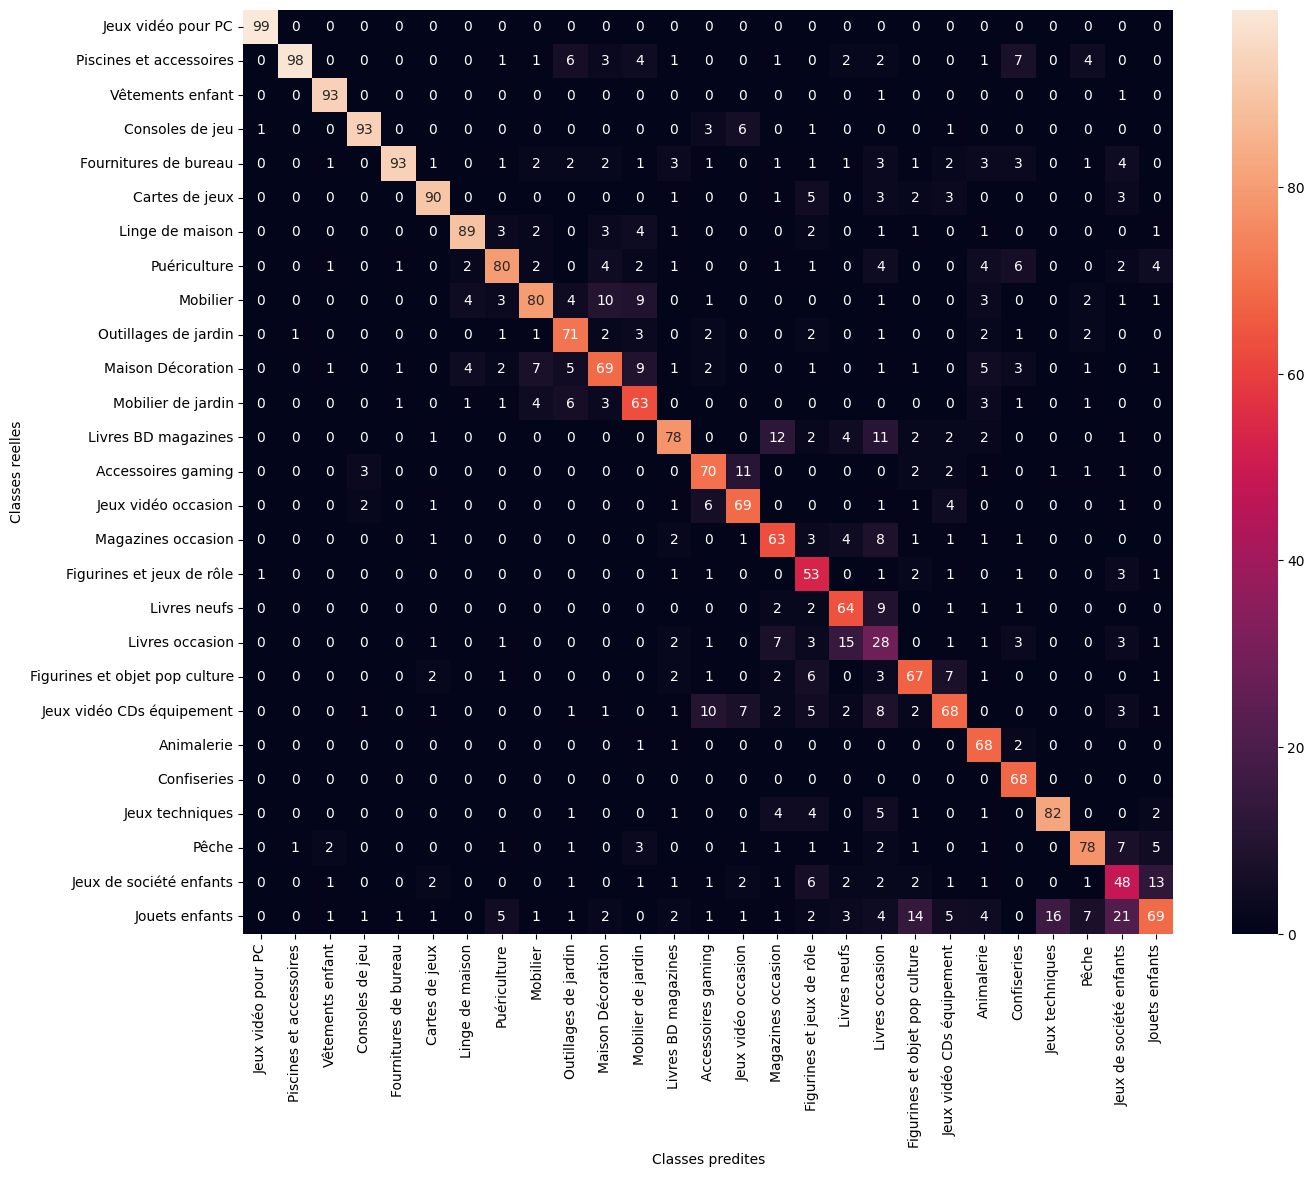

In [81]:
from sklearn.linear_model import LogisticRegression

lgc = LogisticRegression(C=0.5, penalty='l2', dual=False, class_weight='balanced', random_state=123)

params = {'C': np.arange(0.01, 0.11, 0.01)}

gridcv_lgc = GridSearchCV(lgc, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')

gridcv_lgc.fit(X_train_tfidf, y_train);

y_pred_lgc = gridcv_lgc.predict(X_test_tfidf)

print(gridcv_lgc.best_params_)
plot_classification_results(y_test, y_pred_lgc);

## Naive Bayesian Classifier

{'alpha': 0.02, 'fit_prior': True}
                                precision    recall  f1-score   support

            Accessoires gaming       0.76      0.76      0.76       336
                    Animalerie       0.95      0.63      0.76       165
                Cartes de jeux       0.92      0.94      0.93       791
                   Confiseries       0.92      0.90      0.91       161
               Consoles de jeu       0.96      0.78      0.86       166
     Figurines et jeux de rôle       0.82      0.48      0.61       153
Figurines et objet pop culture       0.66      0.79      0.72       534
         Fournitures de bureau       0.92      0.89      0.91       998
       Jeux de société enfants       0.63      0.44      0.52       414
               Jeux techniques       0.80      0.94      0.86      1009
     Jeux vidéo CDs équipement       0.75      0.57      0.65       502
           Jeux vidéo occasion       0.72      0.75      0.74       284
            Jeux vidéo pour 

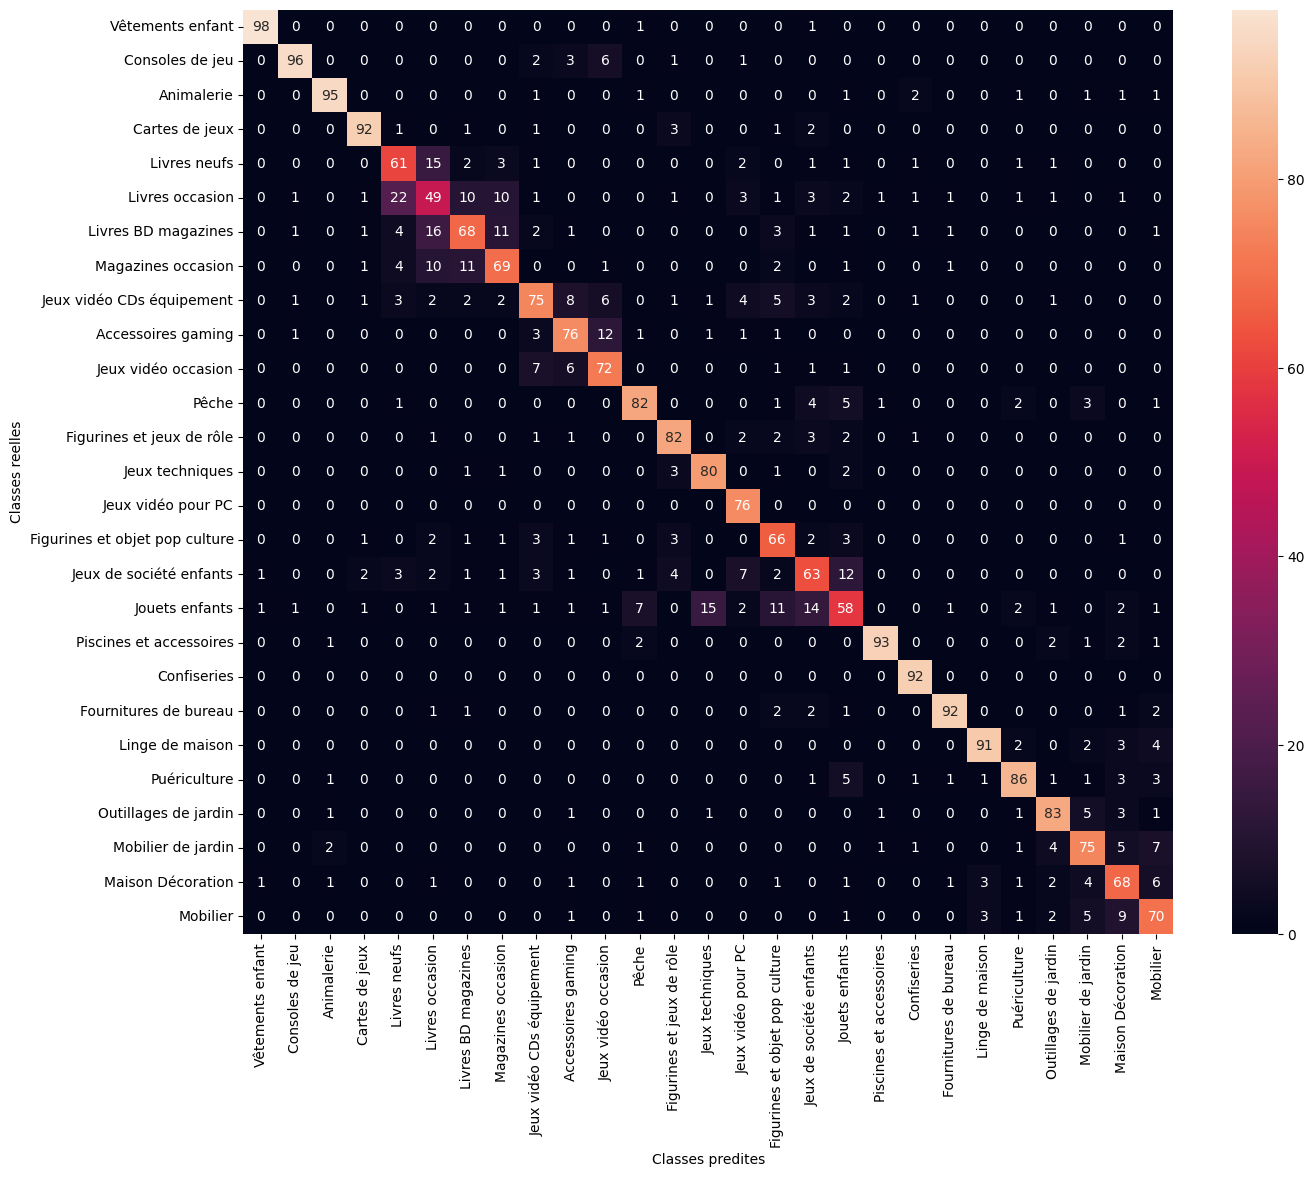

In [11]:
from sklearn.naive_bayes import MultinomialNB

nbc = MultinomialNB(alpha=0.02, fit_prior=True)

params = {'alpha': np.arange(0.01, 0.1, 0.01),
          'fit_prior': [True, False]}

gridcv_nbc = GridSearchCV(nbc, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')
gridcv_nbc.fit(X_train_tfidf, y_train);

y_pred_nbc = gridcv_nbc.predict(X_test_tfidf)

print(gridcv_nbc.best_params_)
plot_classification_results(y_test, y_pred_nbc);


## Linear SVM Classifier

c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                precision    recall  f1-score   support

            Accessoires gaming       0.80      0.82      0.81       336
                    Animalerie       0.89      0.84      0.87       165
                Cartes de jeux       0.92      0.96      0.94       791
                   Confiseries       0.91      0.93      0.92       161
               Consoles de jeu       0.95      0.85      0.90       166
     Figurines et jeux de rôle       0.73      0.56      0.63       153
Figurines et objet pop culture       0.77      0.83      0.80       534
         Fournitures de bureau       0.94      0.94      0.94       998
       Jeux de société enfants       0.68      0.55      0.61       414
               Jeux techniques       0.93      0.95      0.94      1009
     Jeux vidéo CDs équipement       0.75      0.72      0.73       502
           Jeux vidéo occasion       0.82      0.75      0.78       284
            Jeux vidéo pour PC       0.99      0.98      0.99  

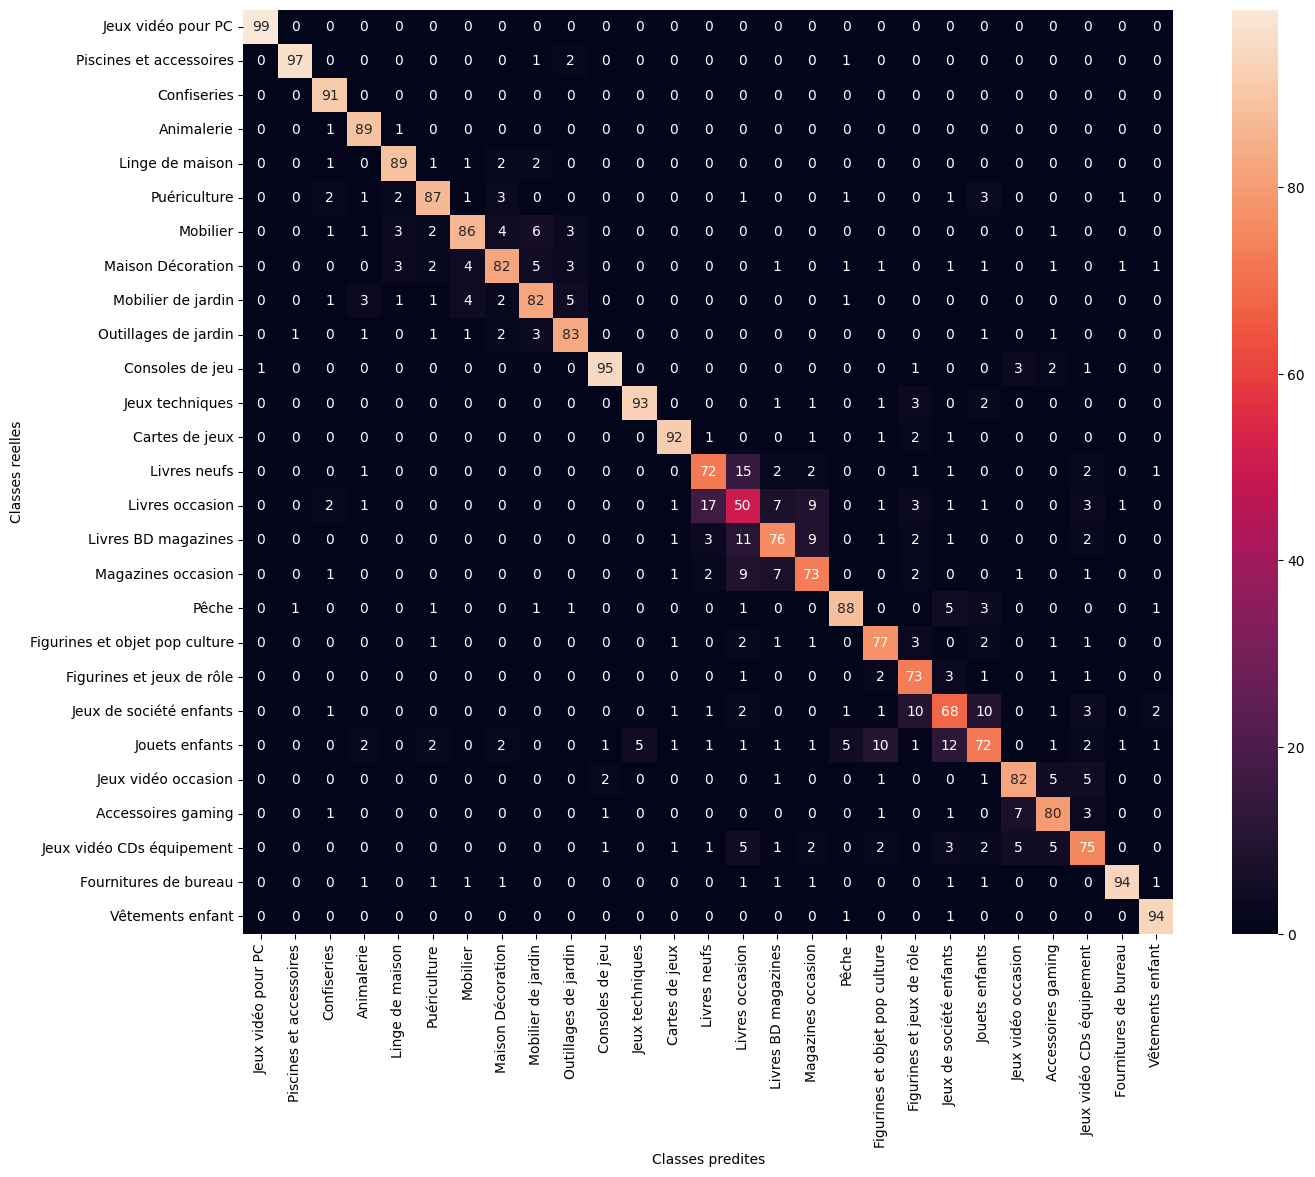

In [12]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

svc = LinearSVC(penalty='l2', C=1, random_state=123, dual='auto', max_iter=10^6, class_weight='balanced')
#f1_weighted = make_scorer(f1_score, average='weighted',labels=y_train.unique()) doesn't work for some reason

params = {'C': np.linspace(0.5, 1.5, 11),
          'penalty': ['l1', 'l2'],
          'class_weight': [None, 'balanced']}

gridcv = GridSearchCV(svc, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')
gridcv.fit(X_train_tfidf, y_train);

y_pred_svc = gridcv.predict(X_test_tfidf)

print(gridcv.best_params_)

plot_classification_results(y_test, y_pred_svc);

### Linear SVC with Bagging

In [398]:
from sklearn.ensemble import BaggingClassifier

svc = LinearSVC(penalty='l2', C=0.7, random_state=123, dual='auto', max_iter=10^6, class_weight=None)

bc = BaggingClassifier(estimator=svc, n_estimators = 50, oob_score = True, random_state = 123)
bc.fit(X_train_tfidf, y_train)
y_pred_svc = bc.predict(X_test_tfidf)

plot_classification_results(y_test, y_pred_svc);

c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: Convergenc

## Classical SVC instead of LinearSVC

In [388]:
from sklearn.svm import SVC

svc = SVC(C=1, random_state=123, kernel='linear')
svc.fit(X_train_tfidf, y_train);
y_pred_svc = svc.predict(X_test_tfidf)

plot_classification_results(y_test, y_pred_svc);

## xgBoost

In [57]:
code, mapping = pd.factorize(target)
mapping =pd.DataFrame({'category': mapping, 'code': range(len(mapping))}, index=mapping)
y_train_xgb = mapping.loc[y_train, 'code']
y_test_xgb = mapping.loc[y_test, 'code']

In [107]:
import xgboost as xgb

clf = xgb.XGBClassifier(objective='multi:softprob',max_depth=6, reg_alpha=0, n_estimators=200)
clf.fit(X_train_tfidf, y_train_xgb)
y_pred_xgb = clf.predict(X_test_tfidf)

plot_classification_results(y_test_xgb, y_pred_xgb, index=mapping);

## Stacking

### SVC with other classifiers

In [93]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb

svc = LinearSVC(penalty='l2', C=0.8, random_state=123, dual='auto')
#xgc = xgb.XGBClassifier(objective='multi:softprob',max_depth=6, reg_alpha=0, n_estimators=200)
nbc = MultinomialNB(alpha=0.02, fit_prior=True)
lgc = LogisticRegression(C=0.5, penalty='l2', dual=False, class_weight='balanced', random_state=123)

sclf = StackingClassifier([('svc', svc), ('nbc', nbc)], final_estimator=lgc, cv=5, n_jobs=-1)

params = {'final_estimator__C': np.arange(0.01, 0.11, 0.01)}

grid_sclf = GridSearchCV(sclf, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')

grid_sclf.fit(X_train_tfidf, y_train_xgb);

y_pred_xgb = grid_sclf.predict(X_test_tfidf)

c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.48      0.58      0.53       623
           1       0.78      0.80      0.79       952
           2       0.83      0.85      0.84       336
           3       0.77      0.65      0.71       974
           4       0.75      0.69      0.72       552
           5       0.95      0.94      0.94       998
           6       0.73      0.79      0.76       518
           7       0.88      0.84      0.86      1015
           8       0.56      0.67      0.61       414
           9       0.91      0.91      0.91       861
          10       0.82      0.74      0.78       955
          11       0.76      0.82      0.79       534
          12       0.99      0.97      0.98      2042
          13       0.55      0.70      0.61       153
          14       0.97      0.94      0.96      1009
          15       0.77      0.77      0.77       284
          16       0.96      0.95      0.95       791
          17       0.84    

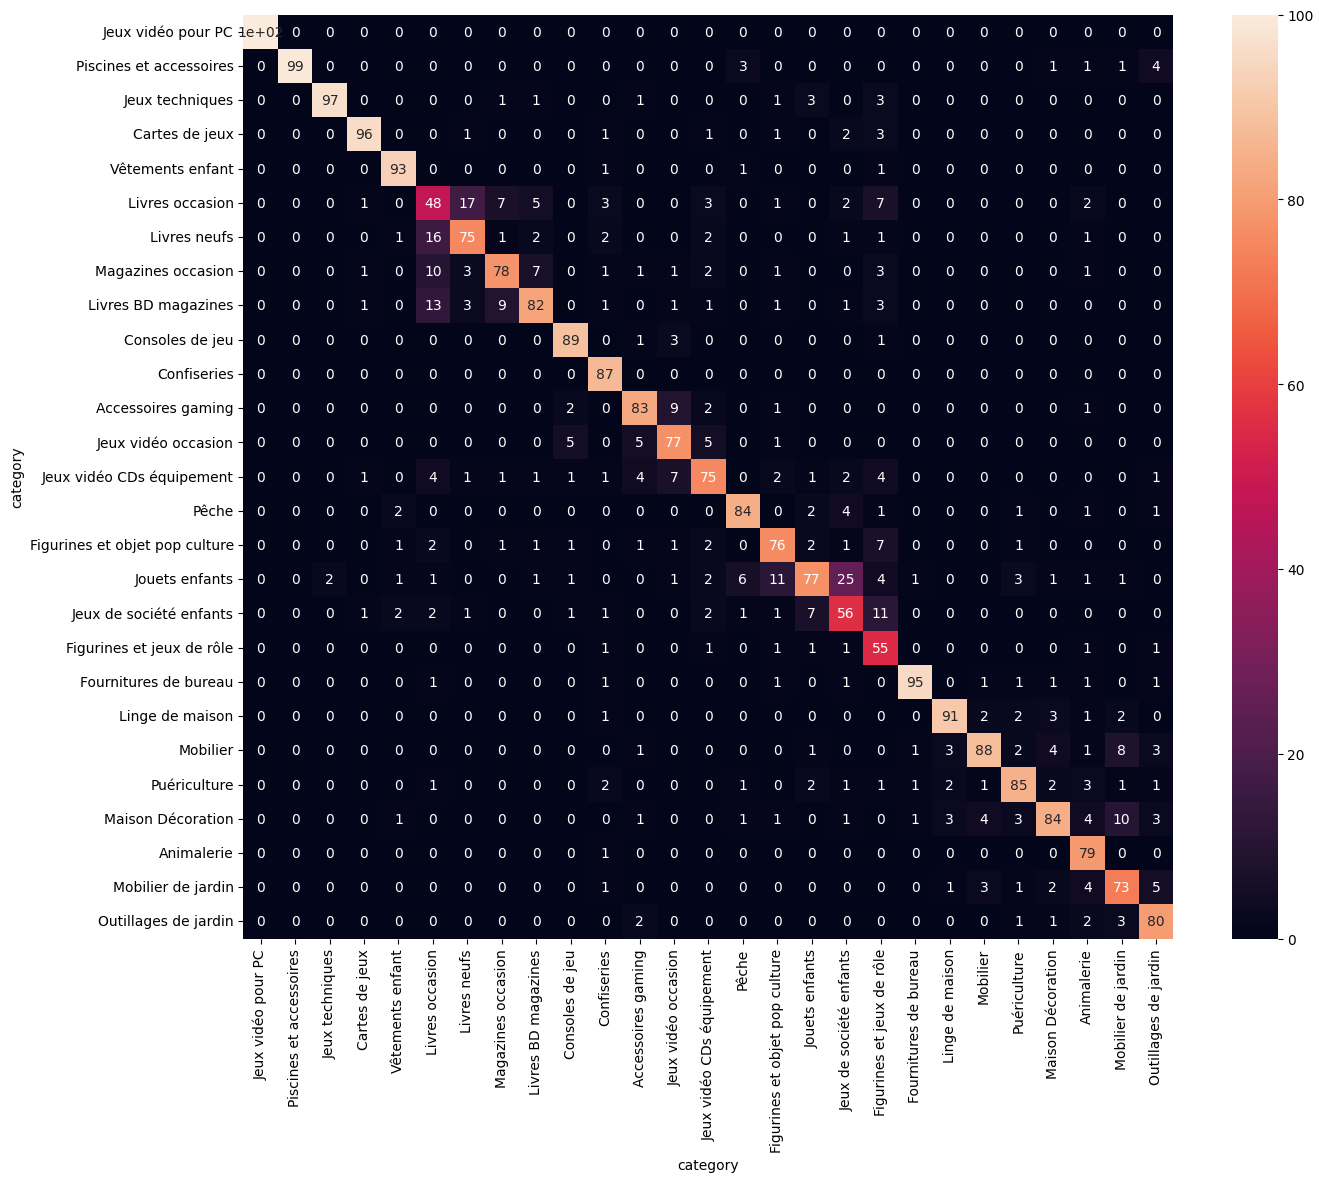

In [80]:
print(grid_sclf.best_params_)
plot_classification_results(y_test_xgb, y_pred_xgb, index=mapping['category']);

## Lazypredict benchmark

In [101]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

lazyclf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazyclf.fit(X_train_tfidf.todense(), X_test_tfidf.todense(), y_train, y_test)
models

  3%|▎         | 1/29 [05:41<2:39:08, 341.02s/it]